In [2]:
import quandl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
quandl.ApiConfig.api_key = 'bULWv51MebBBGL56KGys'

## Fetch Data

##### We will analyze stocks with historically high volatility and large trading volumes, such as large tech companies. Start and end dates were chosen based on availability of options data.

In [20]:
start = '2015-01-01'
end = '2022-02-23'

tickers = ['GOOG', 'AMZN', 'SNAP', 'MSFT', 'FB', 'TSLA', 'NVDA', 'JPM', 'AVGO', 'VZ']

##### Historical adjusted close prices

In [21]:
adj_close = quandl.get_table("QUOTEMEDIA/PRICES", 
                        ticker = tickers,  
                        qopts = { 'columns': ['ticker', 'date', 'adj_close']},  
                        date = { 'gte': start, 'lte': end}, 
                        paginate = True)

In [5]:
adj_close

,ticker,date,adj_close
None,,,
0,VZ,2020-12-31,55.537089
1,VZ,2020-12-30,54.960449
2,VZ,2020-12-29,55.593808
3,VZ,2020-12-28,55.754511
4,VZ,2020-12-24,55.622167
...,...,...,...
14561,AMZN,2015-01-08,300.460000
14562,AMZN,2015-01-07,298.420000
14563,AMZN,2015-01-06,295.290000


##### Financial statement filing date

In [6]:
# earnings dates (FC/FILING_DATE)
zacks_fc = quandl.get_table('ZACKS/FC', 
                    per_end_date = { 'gte': start, 'lte': end },
                    ticker = tickers, 
                    paginate=True)

In [7]:
# quarterly report filing dates
filing_dates = zacks_fc[zacks_fc['per_type'] == 'Q'][['ticker', 'filing_date']]
filing_dates

,ticker,filing_date
None,,
6,AMZN,2015-04-24
7,AMZN,2015-07-24
8,AMZN,2015-10-23
9,AMZN,2016-01-29
10,AMZN,2016-04-29
...,...,...
292,VZ,2020-02-21
293,VZ,2020-04-27
294,VZ,2020-07-28


##### Historical option data

Historical options data is sourced from the WRDS dataset "OptionMetrics - Option Prices".

In [8]:
# this is limited to options with expiry less than 8 days from current date.
option_data = pd.read_csv('data/OptionMetrics.csv.gz', sep = ',')

In [9]:
# match date format of quandl data
option_data['date'] = option_data.apply(lambda row: row.date.replace('/', '-', 2), axis = 1)
option_data['exdate'] = option_data.apply(lambda row: row.exdate.replace('/', '-', 2), axis = 1)

In [10]:
# strike_price = strike * 1000
option_data

,date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,vega,theta,optionid,ticker,index_flag,issuer,exercise_style
0,2015-01-02,2015-01-09,C,235000,71.90,75.55,0,0,0.919228,0.986198,0.000899,1.508328,-36.45721,106179177,AMZN,0,AMAZON.COM INC.,A
1,2015-01-02,2015-01-09,C,240000,67.00,70.85,0,2,0.955372,0.975301,0.001419,2.475758,-61.95087,106179178,AMZN,0,AMAZON.COM INC.,A
2,2015-01-02,2015-01-09,C,245000,61.85,65.35,0,0,0.695843,0.992689,0.000682,0.864939,-16.05143,106134398,AMZN,0,AMAZON.COM INC.,A
3,2015-01-02,2015-01-09,C,250000,57.15,60.45,0,0,0.771536,0.978447,0.001567,2.201530,-44.71402,106134399,AMZN,0,AMAZON.COM INC.,A
4,2015-01-02,2015-01-09,C,255000,52.00,55.45,0,0,0.673865,0.981649,0.001565,1.925056,-34.15807,106134400,AMZN,0,AMAZON.COM INC.,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2538404,2020-12-30,2020-12-31,P,64000,14.55,14.70,0,0,NaN,NaN,NaN,NaN,NaN,137663387,SNAP,0,SNAP INC,A
2538405,2020-12-30,2020-12-31,P,65000,15.55,15.70,0,1,NaN,NaN,NaN,NaN,NaN,137439703,SNAP,0,SNAP INC,A
2538406,2020-12-30,2020-12-31,P,66000,16.55,16.85,0,0,2.638148,-0.979169,0.007363,0.129699,-62.33575,137663388,SNAP,0,SNAP INC,A
2538407,2020-12-30,2020-12-31,P,67000,17.55,17.75,0,0,NaN,NaN,NaN,NaN,NaN,137663389,SNAP,0,SNAP INC,A


## High-level Data Analysis

In [26]:
# create rolling realized vol from adj_close df

close_volatility = pd.DataFrame() 

for t in adj_close.ticker.unique():
    df = adj_close[adj_close['ticker'] == t]
    df['7 day window'] = df['adj_close'].rolling(7).std() * np.sqrt(252) / 100
    df['14 day window'] = df['adj_close'].rolling(14).std() * np.sqrt(252) / 100
    close_volatility = pd.concat([close_volatility, df], axis = 0)
    

close_volatility = close_volatility.rename(columns = {0: "7 day window"})
#close_volatility = close_volatility.rename(columns = {0: "14 day window"})
close_volatility = pd.concat([adj_close, close_volatility], axis = 1)
close_volatility

/var/folders/sj/vqp874yx4pn9gj3fk_gz4rzw0000gn/T/ipykernel_25234/669655109.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['7 day window'] = df['adj_close'].rolling(7).std() * np.sqrt(252) / 100
/var/folders/sj/vqp874yx4pn9gj3fk_gz4rzw0000gn/T/ipykernel_25234/669655109.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['14 day window'] = df['adj_close'].rolling(14).std() * np.sqrt(252) / 100


,ticker,date,adj_close,ticker,date,adj_close,7 day window,14 day window
None,,,,,,,,
0,VZ,2022-02-23,53.41,VZ,2022-02-23,53.41,NaN,NaN
1,VZ,2022-02-22,53.90,VZ,2022-02-22,53.90,NaN,NaN
2,VZ,2022-02-18,53.83,VZ,2022-02-18,53.83,NaN,NaN
3,VZ,2022-02-17,53.58,VZ,2022-02-17,53.58,NaN,NaN
4,VZ,2022-02-16,53.40,VZ,2022-02-16,53.40,NaN,NaN
...,...,...,...,...,...,...,...,...
17441,AMZN,2015-01-08,300.46,AMZN,2015-01-08,300.46,0.700056,1.341160
17442,AMZN,2015-01-07,298.42,AMZN,2015-01-07,298.42,0.724128,1.321268
17443,AMZN,2015-01-06,295.29,AMZN,2015-01-06,295.29,0.488910,1.270727


In [12]:
amzn_options = pd.DataFrame(option_data[option_data['ticker'] == 'AMZN'])

In [13]:
amzn_options

,date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,vega,theta,optionid,ticker,index_flag,issuer,exercise_style
0,2015-01-02,2015-01-09,C,235000,71.90,75.55,0,0,0.919228,0.986198,0.000899,1.508328,-36.45721,106179177,AMZN,0,AMAZON.COM INC.,A
1,2015-01-02,2015-01-09,C,240000,67.00,70.85,0,2,0.955372,0.975301,0.001419,2.475758,-61.95087,106179178,AMZN,0,AMAZON.COM INC.,A
2,2015-01-02,2015-01-09,C,245000,61.85,65.35,0,0,0.695843,0.992689,0.000682,0.864939,-16.05143,106134398,AMZN,0,AMAZON.COM INC.,A
3,2015-01-02,2015-01-09,C,250000,57.15,60.45,0,0,0.771536,0.978447,0.001567,2.201530,-44.71402,106134399,AMZN,0,AMAZON.COM INC.,A
4,2015-01-02,2015-01-09,C,255000,52.00,55.45,0,0,0.673865,0.981649,0.001565,1.925056,-34.15807,106134400,AMZN,0,AMAZON.COM INC.,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2123348,2020-12-30,2020-12-31,P,4100000,811.55,814.25,0,0,NaN,NaN,NaN,NaN,NaN,137150828,AMZN,0,AMAZON.COM INC.,A
2123349,2020-12-30,2020-12-31,P,4110000,821.70,824.15,0,0,NaN,NaN,NaN,NaN,NaN,137654405,AMZN,0,AMAZON.COM INC.,A
2123350,2020-12-30,2020-12-31,P,4120000,831.75,834.20,0,0,NaN,NaN,NaN,NaN,NaN,137654406,AMZN,0,AMAZON.COM INC.,A
2123351,2020-12-30,2020-12-31,P,4150000,861.85,864.25,0,0,NaN,NaN,NaN,NaN,NaN,137150829,AMZN,0,AMAZON.COM INC.,A


In [14]:
# does not account for weekends and holidays
entry_dates = pd.to_datetime(filing_dates['filing_date']) - datetime.timedelta(days=1)
exit_dates = pd.to_datetime(filing_dates['filing_date']) + datetime.timedelta(days=1)

In [15]:
# entry_dates = pd.to_datetime(filing_dates['filing_date']) - datetime.timedelta(days=1)
# exit_dates = pd.to_datetime(filing_dates['filing_date']) + datetime.timedelta(days=1)

In [16]:
# compare realized vol on day before filing_date to vol of short dated straddle

In [17]:
# graph of price moves after earnings 

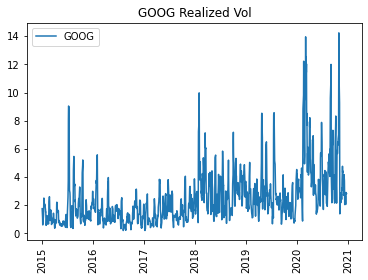

In [24]:
for stock in ['GOOG']:
    df = close_volatility[close_volatility['ticker'] == stock]
    plt.plot(df['date'], df['7 day window'], label = '7 day{}'.format(stock))
    plt.plot(df['date'], df['14 day window'], label = '14 day{}'.format(stock))
plt.legend()
plt.title('GOOG Realized Vol')
plt.xticks(rotation = 90)
# plt.savefig('GOOG_AMZN.png',bbox_inches ="tight", pad_inches = 0.5, facecolor ="w")
plt.show()

In [19]:
df[df['date'] > '2020-01-08']

,ticker,date,adj_close
None,,,
8522,GOOG,2020-12-31,1751.88
8523,GOOG,2020-12-30,1739.52
8524,GOOG,2020-12-29,1758.72
8525,GOOG,2020-12-28,1776.09
8526,GOOG,2020-12-24,1738.85
8527,GOOG,2020-12-23,1732.38
8528,GOOG,2020-12-22,1723.50
8529,GOOG,2020-12-21,1739.37
8530,GOOG,2020-12-18,1731.01
